<a href="https://colab.research.google.com/github/mahshidkhatiri/MachineLearning/blob/main/abalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

"""
Created on Wed Sep 20 21:12:10 2023

@author: Mahshid
"""
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import IPython
!pip install -q -U keras-tuner
import keras_tuner as kt
print('IPython version:', IPython.__version__, 'Keras Tuner version:', kt.__version__)

IPython version: 7.34.0 Keras Tuner version: 1.4.3


In [ ]:

data = pd.read_csv( "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",
                   header=None,
                   names = ["Sex","Length","Diameter","Height","whole_weight","Shucked_weight","Viscera_weight","Shell_weight","Rings"]
                   )
gender_codes = {'Sex': {"F": 0, "M": 1, "I": 2}}
data.replace(gender_codes, inplace=True)
data.head()
train, validation = train_test_split(data, test_size=0.5, random_state=42)

train_labels = train.iloc[:,0]
val_labels = validation.iloc[:,0]
x_train=train.drop(['Sex'], axis=1)
x_valid=validation.drop(['Sex'], axis=1)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 90)                810       
                                                                 
 dense_9 (Dense)             (None, 120)               10920     
                                                                 
 dense_10 (Dense)            (None, 170)               20570     
                                                                 
 dense_11 (Dense)            (None, 3)                 513       
                                                                 
Total params: 32813 (128.18 KB)
Trainable params: 32813 (128.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


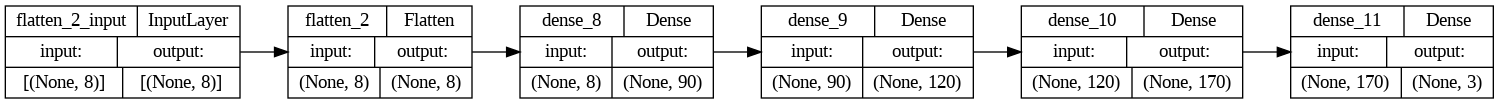

In [ ]:


model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[8]),
keras.layers.Dense(90, activation="relu"),
keras.layers.Dense(120, activation="relu"),
keras.layers.Dense(170, activation="relu"),
keras.layers.Dense(3, activation="softmax")])

model.summary()
keras.utils.plot_model(model, "abalone-db.png", show_shapes=True,rankdir='LR')

In [ ]:


model.compile(loss="sparse_categorical_crossentropy",
optimizer="Adam",
metrics=["accuracy"])

Epoch 1/100
66/66 [==============================] - 3s 25ms/step - loss: 0.9018 - accuracy: 0.5254 - val_loss: 0.8593 - val_accuracy: 0.5567
Epoch 2/100
66/66 [==============================] - 0s 7ms/step - loss: 0.8543 - accuracy: 0.5570 - val_loss: 0.8613 - val_accuracy: 0.5505
Epoch 3/100
66/66 [==============================] - 1s 13ms/step - loss: 0.8461 - accuracy: 0.5517 - val_loss: 0.8578 - val_accuracy: 0.5548
Epoch 4/100
66/66 [==============================] - 1s 13ms/step - loss: 0.8373 - accuracy: 0.5661 - val_loss: 0.8406 - val_accuracy: 0.5601
Epoch 5/100
66/66 [==============================] - 1s 11ms/step - loss: 0.8324 - accuracy: 0.5723 - val_loss: 0.8515 - val_accuracy: 0.5716
Epoch 6/100
66/66 [==============================] - 1s 8ms/step - loss: 0.8282 - accuracy: 0.5704 - val_loss: 0.8537 - val_accuracy: 0.5558
Epoch 7/100
66/66 [==============================] - 1s 10ms/step - loss: 0.8214 - accuracy: 0.5757 - val_loss: 0.8409 - val_accuracy: 0.5697
Epoch 8/

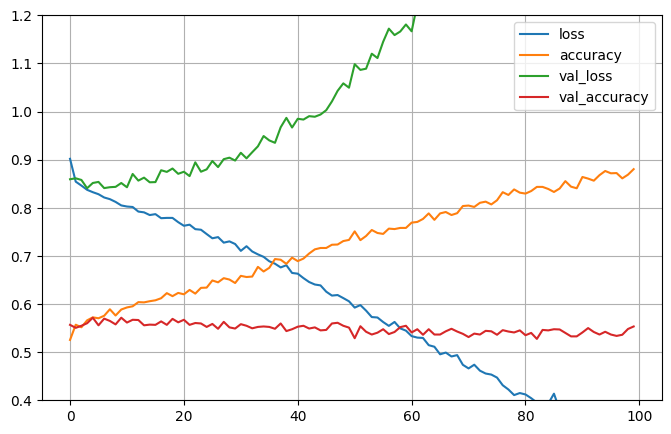

In [ ]:
history = model.fit(x_train, train_labels, epochs=100, validation_data=(x_valid, val_labels), verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 1.2)
plt.savefig('abalone-b.png')
plt.show()

In [ ]:
def model_builder(hp):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[8]))
  hp_units_1 = hp.Int('units_1', min_value = 50, max_value = 200, step = 10)
  model.add(keras.layers.Dense(units = hp_units_1, activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model. add(keras.layers.Dropout(rate=0.4))
  hp_units_2 = hp.Int('units_2', min_value = 0, max_value = 150, step = 10)
  model.add(keras.layers.Dense(units = hp_units_2, activation="relu"))
  model. add(keras.layers.Dropout(rate=0.4))
  model.add(keras.layers.BatchNormalization())
  hp_units_3 = hp.Int('units_3', min_value = 0, max_value = 150, step = 10)
  model.add(keras.layers.Dense(units = hp_units_3, activation="relu"))
  model. add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(3, activation='softmax'))

  # Tune the optimizer:
  hp_optimizer = hp.Choice('optimizer', ['Adam', 'RMSProp', 'SGD', 'Adagrad', 'Adamax'])
  model.compile(optimizer = hp_optimizer,
                loss = "sparse_categorical_crossentropy",
                metrics = ['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     overwrite = True)

In [ ]:
tuner.search(x_train, train_labels, epochs = 10, validation_data=(x_valid, val_labels))

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.5505026578903198

Best val_accuracy So Far: 0.5658209919929504
Total elapsed time: 00h 02m 04s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model_e = tuner.hypermodel.build(best_hps)
history_e = model_e.fit(x_train, train_labels, epochs = 100, validation_data = (x_valid, val_labels), verbose=1)
model_e.summary()

Epoch 1/100
66/66 [==============================] - 2s 9ms/step - loss: 1.2642 - accuracy: 0.4674 - val_loss: 0.9475 - val_accuracy: 0.5467
Epoch 2/100
66/66 [==============================] - 0s 5ms/step - loss: 1.0950 - accuracy: 0.4813 - val_loss: 0.9221 - val_accuracy: 0.5194
Epoch 3/100
66/66 [==============================] - 0s 5ms/step - loss: 1.0254 - accuracy: 0.5048 - val_loss: 0.9120 - val_accuracy: 0.5347
Epoch 4/100
66/66 [==============================] - 0s 6ms/step - loss: 0.9656 - accuracy: 0.5062 - val_loss: 0.8992 - val_accuracy: 0.5247
Epoch 5/100
66/66 [==============================] - 0s 5ms/step - loss: 0.9465 - accuracy: 0.5292 - val_loss: 0.9286 - val_accuracy: 0.4964
Epoch 6/100
66/66 [==============================] - 0s 5ms/step - loss: 0.9323 - accuracy: 0.5072 - val_loss: 0.8812 - val_accuracy: 0.5519
Epoch 7/100
66/66 [==============================] - 0s 5ms/step - loss: 0.9226 - accuracy: 0.5407 - val_loss: 0.8714 - val_accuracy: 0.5452
Epoch 8/100
6

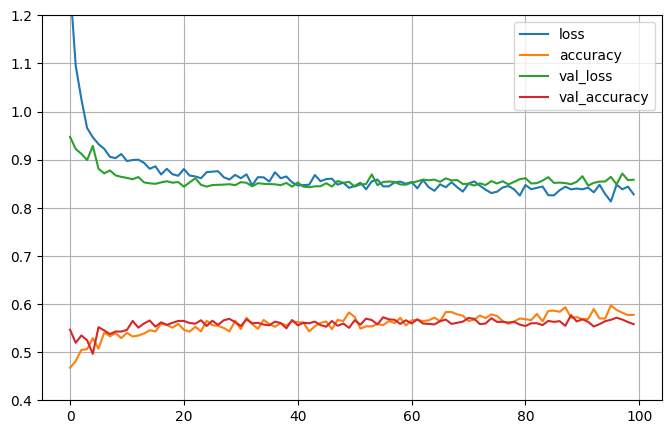

In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history_e.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 1.2)
plt.savefig('abalone-c.png')
plt.show()

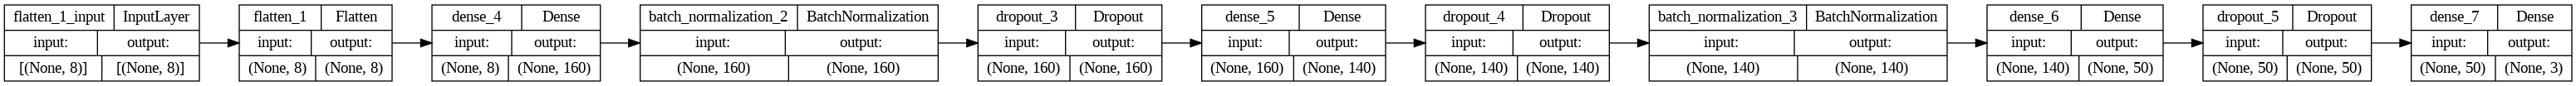

In [ ]:
keras.utils.plot_model(model_e, "abalone-dc.png", show_shapes=True, rankdir='LR')